In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Used to do plots
%matplotlib inline

import nltk 
from nltk.corpus import stopwords # Stopwords 
from nltk.tokenize import word_tokenize # Word_tokenizer
from nltk.stem.porter import PorterStemmer
from pattern.text.en import singularize

from pandarallel import pandarallel # Parallel workers on pandas dataframe

import unidecode
import re 
import time
import string
import statistics

from datetime import datetime

import contractions

In [2]:
df_reviews_dataset = pd.read_csv('IMDB/DS/dataset.csv')

In [3]:
df_reviews_dataset

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_text_count,cleaned_review_stemming,cleaned_review
0,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,9,redempt without doubt one brilliant movi ever ...,redemption without doubt one brilliant movie e...
1,9 October 2005,tt0111161,ur6574726,True,I have been a fan of this movie for a long tim...,9,This Movie Saved My Life.,7,fan movi long time seem ever time life hit dow...,fan movie long time seem ever time life hit do...
2,4 February 2012,tt0111161,ur31182745,True,I made my account on IMDb Just to Rate this mo...,10,Movie you can see 1000 times,8,made account rate movi someon robin done great...,made account rate movie someone robin done gre...
3,24 October 2008,tt0111161,ur9871443,True,"A friend of mine listed ""The Shawshank Redempt...",10,The Shawshank Redemption,6,friend mine list redempt one time favorit movi...,friend mine listed redemption one time favorit...
4,1 June 2010,tt0111161,ur23169472,True,"To tell the truth, I am speechless. I am a you...",10,"Blatantly Simple, yet Utterly Beautiful",9,tell truth young movi fanat fact film came yea...,tell truth young movie fanatic fact film came ...
...,...,...,...,...,...,...,...,...,...,...
279665,14 August 1999,tt0139239,ur0415521,False,This type of movie is one that I would not ord...,9,GO see it!,5,type movi one would ordinarili see howev becom...,type movie one would ordinarily see however be...
279666,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,4,go wise fast pure entertain except cast turn m...,go wise fast pure entertainment exceptional ca...
279667,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie,7,well shall say one fun rate three one point go...,well shall say one fun rate three one point go...
279668,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?,7,call teenag version pulp fiction whatev want p...,call teenage version pulp fiction whatever wan...


### Undersampling

In [4]:
df_non = df_reviews_dataset[df_reviews_dataset['is_spoiler'] == False]
df_spoiler = df_reviews_dataset[df_reviews_dataset['is_spoiler'] == True]
print("nonspoiler:", len(df_non))
print("spoiler:", len(df_spoiler))

nonspoiler: 227256
spoiler: 52414


In [5]:
df_non = df_non.sample(frac =.5)
print("weight-decreased nonspoiler:", len(df_non))
print("spoiler:", len(df_spoiler))
print("balanced total:", len(df_non)+len(df_spoiler))

weight-decreased nonspoiler: 113628
spoiler: 52414
balanced total: 166042


In [6]:
# 70/10/20 train/val/test
df_train_non = df_non.sample(frac = .80)
df_non = df_non.drop(df_train_non.index)

df_train_spoiler = df_spoiler.sample(frac = .80)
df_spoiler = df_spoiler.drop(df_train_spoiler.index)

# use all of the remaining for test (which is 20% of whole dataset)
df_test_non = df_non
df_test_spoiler = df_spoiler

In [7]:
# merge and shuffle

df_train = pd.concat([df_train_non, df_train_spoiler])
#df_train = df_train.sample(frac=1).reset_index(drop=True)


df_test = pd.concat([df_test_non, df_test_spoiler])
#df_test = df_test.sample(frac=1).reset_index(drop=True)

print("train:",len(df_train))
print("test:",len(df_test))
print("all:",len(df_train)+len(df_test))

train: 132833
test: 33209
all: 166042


Divide the dataset in X and y, we load the dataset with stemming to check if the stemming is useful to improve the model measures.

In [8]:
X = df_train.cleaned_review
X_stemming = df_train.cleaned_review_stemming
y = df_train.is_spoiler

### Model Evaluation & Selection
in this section we have performed all the operation needed to evalute and select the model. As the task is a binary classification problem, we have analyzed the performances of three types of classification models:

- Naive Bayes Multinomial
- Support Vector Machine
- Logistic Regression

To do these operations and handle the dataset distribution we have used the sklean and imblearn libraries. \ We have performed the K-cross validation to evalute the model and select it.

In [9]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [10]:
def print_kfold_scores(scores):
    print("Accuracy = ", scores['test_accuracy'])
    print("")
    print("Precision = ", scores['test_precision'])
    print("")
    print("Recall = ", scores['test_recall'])
    print("")
    print("F1 score = ", scores['test_f1_score'])
    print("\n-----------------------------------------------------\n")
    print("fit_time (s) = ", scores['fit_time'])
    print("")
    print("score_time (s) = ", scores['score_time'])

In [11]:
def print_cross_validation(score, stemming):
    if stemming:
        print("--------------    K-FOLD WITH STEMMING    --------------\n")
        print_kfold_scores(score)
    else:
        print("--------------    K-FOLD WITHOUT STEMMING    --------------\n")
        print_kfold_scores(score)

In [12]:
scoring = {
    'accuracy' : make_scorer(accuracy_score), 
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score), 
    'f1_score' : make_scorer(f1_score)
}

In [13]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_folds)

In [14]:
def apply_cross_validation(clf, X, y, ngrams = (1,1), sampling_ratio = -1, n_jobs = 5, stemming = False):
    '''
    
    '''
    
    if sampling_ratio == -1: 
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('clf', clf)
        ])
    else:
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('rus', RandomUnderSampler(sampling_strategy=sampling_ratio)),
            ('clf', clf)
        ])
    
    score = cross_validate(clf_pipeline, X, y, cv = skf, scoring=scoring, n_jobs = n_jobs)
    
    print_cross_validation(score, stemming)
    
    return clf_pipeline, score

### COMPARE MODELS USING DATASET DISTRIBUTION
- We have applied the cross-validation with imbalanced-distribution to compare how classifier works on the general dataset and decide which models analyze in more details.

1. MULTINOMIAL

In [15]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(MultinomialNB(), X, y) 

# Register average precision and recall
avg_multinomial_precision = statistics.mean(score['test_precision'])
avg_multinomial_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.69745559 0.7030262  0.70152063 0.69833622 0.69856207 0.70202514
 0.70067003 0.70021832 0.69901378 0.70097117]

Precision =  [0.64646465 0.7137931  0.6892562  0.66548043 0.67213115 0.7221172
 0.68935428 0.678511   0.67504488 0.69488536]

Recall =  [0.09158121 0.09873599 0.09942775 0.08919628 0.08800382 0.09110422
 0.09420463 0.09563558 0.08967326 0.09396613]

F1 score =  [0.16043451 0.1734758  0.17378621 0.1573081  0.15563054 0.16179585
 0.16575745 0.16764214 0.15831579 0.16554622]

-----------------------------------------------------

fit_time (s) =  [5.8608861  6.10414433 5.89865708 5.93442178 5.96711278 6.00151014
 5.97180629 5.90679622 5.92323756 5.97667694]

score_time (s) =  [0.72054744 0.73716235 0.66312289 0.80198741 0.80685353 0.70932269
 0.63572025 0.62386203 0.64881063 0.61686134]


2. SVM

In [16]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y)

# Register average precision and recall
avg_svm_precision = statistics.mean(score['test_precision'])
avg_svm_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.7254592  0.72982535 0.73125565 0.72566438 0.72626666 0.72822405
 0.72732064 0.72438455 0.72935331 0.72732064]

Precision =  [0.59472588 0.60894661 0.61079545 0.59800071 0.60079624 0.60550127
 0.60049278 0.59459459 0.60498596 0.60370505]

Recall =  [0.40877653 0.40257572 0.41010968 0.39947532 0.39589793 0.39899833
 0.40686859 0.39875984 0.41092297 0.39637491]

F1 score =  [0.48452297 0.48470926 0.49072753 0.47898198 0.4772858  0.48102358
 0.4850725  0.4773733  0.48941912 0.47854881]

-----------------------------------------------------

fit_time (s) =  [10.33399367 10.43690205 10.34187865 10.31778526 10.19450879 10.4019568
 10.42409158 10.38315248 10.21453786 10.21861839]

score_time (s) =  [0.69783211 0.69752717 0.69052219 0.77938676 0.79368687 0.69163513
 0.68287849 0.67604113 0.66229296 0.62188768]


3. LOGISTIC

In [17]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y)

# Register average precision and recall
avg_logistic_precision = statistics.mean(score['test_precision'])
avg_logistic_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.73629931 0.73953628 0.74013851 0.73447263 0.73349394 0.74282918
 0.7370323  0.7356019  0.73770985 0.73432207]

Precision =  [0.63877715 0.65549427 0.65747029 0.64122137 0.64030941 0.66538953
 0.64919011 0.64594942 0.64594483 0.64139693]

Recall =  [0.37872645 0.36847126 0.36933715 0.360601   0.35535416 0.37276413
 0.36322442 0.35940854 0.37419509 0.35917005]

F1 score =  [0.47552029 0.47175573 0.4729771  0.46160891 0.45705521 0.47783552
 0.46582046 0.46184493 0.47387496 0.46048005]

-----------------------------------------------------

fit_time (s) =  [14.92054582 13.77290273 13.60211205 14.31327486 14.2218647  15.52633238
 13.94021702 15.45724249 14.83387661 14.67006278]

score_time (s) =  [0.74517846 0.80081964 0.81693482 0.74231935 0.72523403 0.6930573
 0.84058523 0.56311226 0.6560216  0.67547703]


---

In [18]:
pd.DataFrame([
    [avg_multinomial_precision, avg_multinomial_recall],
    [avg_svm_precision, avg_svm_recall],
    [avg_logistic_precision, avg_logistic_recall]
], index = ['Multinomial', 'SVM', 'Logistic'], columns=['AVG_Precision', 'AVG_Recall'])

,AVG_Precision,AVG_Recall
Multinomial,0.684704,0.093153
SVM,0.602254,0.402876
Logistic,0.648114,0.366125


COMPARE THE MODELS PLOTTING AVG PRECISION-RECALL

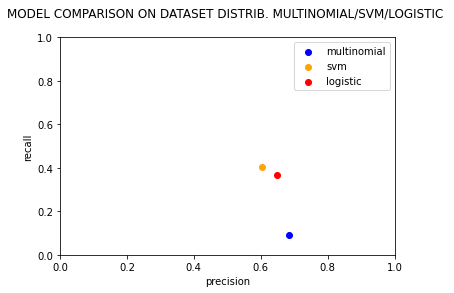

In [19]:
plt.scatter(avg_multinomial_precision, avg_multinomial_recall, color ='blue')
plt.scatter(avg_svm_precision, avg_svm_recall, color ='orange')
plt.scatter(avg_logistic_precision, avg_logistic_recall, color ='red')
labels = ["multinomial", "svm", "logistic"]

plt.xlim([0, 1]) 
plt.ylim([0, 1]) 

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=labels)

plt.title('MODEL COMPARISON ON DATASET DISTRIB. MULTINOMIAL/SVM/LOGISTIC \n')

plt.show()

As we can see from the plot, the multinomial model works really bad in terms of precision and recall in respect to the other two classifiers. 

Due to this, we have decided to perform the analysis changing parameters and distribution only to SVM and Logistic models.

### COMPARING SVM AND LOGISTIC SCORE
In this section we have compared the SVM and Logistic model changing parameters of CountVectorizer and the distribution of the classes.

We have also analyzed if the stemming is relevant in terms of increasing the model's performances.

#### SVM

In [20]:
from sklearn.svm import LinearSVC
svm_pipelines = []
svm_scores = []

Ngram_range (1,1) & dataset distribution

In [21]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.7254592  0.72990063 0.73125565 0.72566438 0.72626666 0.72822405
 0.72732064 0.72438455 0.72935331 0.72732064]

Precision =  [0.59472588 0.60916637 0.61079545 0.59800071 0.60079624 0.60550127
 0.60049278 0.59459459 0.60498596 0.60370505]

Recall =  [0.40877653 0.40257572 0.41010968 0.39947532 0.39589793 0.39899833
 0.40686859 0.39875984 0.41092297 0.39637491]

F1 score =  [0.48452297 0.48477886 0.49072753 0.47898198 0.4772858  0.48102358
 0.4850725  0.4773733  0.48941912 0.47854881]

-----------------------------------------------------

fit_time (s) =  [10.65392995 10.56200147 10.61085248 10.64330411 10.6073308  10.68170357
 10.65187001 10.69042873 10.62137413 10.48283768]

score_time (s) =  [0.6892283  0.68777609 0.730196   0.72734523 0.72968984 0.69525909
 0.68518353 0.66908622 0.65088153 0.62384582]


In [22]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.72741644 0.72854562 0.72997591 0.72784762 0.72340586 0.73198826
 0.73055786 0.72656779 0.73206354 0.72829933]

Precision =  [0.60149042 0.6079441  0.61048416 0.6055515  0.5952993  0.61911931
 0.61311717 0.60400445 0.61611722 0.6093633 ]

Recall =  [0.40424517 0.39422848 0.39985694 0.39542094 0.38659671 0.39232053
 0.3968519  0.38850465 0.40114477 0.38802767]

F1 score =  [0.48352589 0.47829861 0.48321567 0.47843024 0.46876807 0.48029197
 0.48183003 0.47285922 0.48591651 0.47413667]

-----------------------------------------------------

fit_time (s) =  [10.36216187 10.32117939 10.35870743 10.18963456 10.15500998 10.45149302
 10.52623177 10.41685843 10.36645246 10.22694445]

score_time (s) =  [0.65476561 0.63667274 0.6513412  0.72992015 0.74458861 0.64129615
 0.64636254 0.61520553 0.62533498 0.62234306]


- Ngram_range (1,2) & dataset distribution

In [23]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.71815718 0.73396567 0.72847034 0.7241587  0.72656779 0.73552661
 0.72671836 0.7255891  0.73123541 0.72777234]

Precision =  [0.55943871 0.59300028 0.58177765 0.57272477 0.57811195 0.59460211
 0.57684958 0.5749453  0.58485426 0.58138223]

Recall =  [0.50393513 0.50107322 0.49785408 0.49678035 0.4951109  0.50965896
 0.50393513 0.50131171 0.51204388 0.49153351]

F1 score =  [0.53023839 0.54317477 0.53655403 0.53205619 0.53340185 0.54886349
 0.53793279 0.53560963 0.54603255 0.53269579]

-----------------------------------------------------

fit_time (s) =  [43.11683416 43.40372896 43.00208974 43.07696986 43.37455297 43.20914602
 43.0634675  42.72623897 42.90305972 43.1132431 ]

score_time (s) =  [2.26518416 2.21026683 2.20578146 2.2496767  2.62976336 2.30102968
 2.2833612  2.26728702 2.24946451 2.06566072]


In [24]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.72320084 0.73306233 0.72884673 0.72408341 0.72506211 0.73936611
 0.73153655 0.72408341 0.72837461 0.72927802]

Precision =  [0.57080132 0.59472914 0.58328644 0.57478754 0.57591917 0.60560532
 0.58903721 0.57361963 0.58241758 0.58689956]

Recall =  [0.49606487 0.48437873 0.49427754 0.48390174 0.48938707 0.49988075
 0.49463391 0.49057954 0.49296446 0.48080134]

F1 score =  [0.53081536 0.53391167 0.53510583 0.52544348 0.52913873 0.54768748
 0.53772362 0.52885975 0.53397055 0.52857892]

-----------------------------------------------------

fit_time (s) =  [40.73781657 40.85811114 41.18200016 40.92694712 41.25438666 41.10352278
 40.80594087 40.23863411 40.4627254  40.67227864]

score_time (s) =  [2.25278616 2.20803595 2.42365646 2.20248723 2.44707894 2.15708065
 2.15613246 2.21335411 2.21641541 2.08104086]


#### Logsitic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
logistic_pipelines = []
logistic_scores = []

- Ngram_range (1,1) & dataset distribution

In [26]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.73629931 0.73953628 0.74013851 0.73447263 0.73349394 0.74282918
 0.7370323  0.7356019  0.73770985 0.73432207]

Precision =  [0.63877715 0.65549427 0.65747029 0.64122137 0.64030941 0.66538953
 0.64919011 0.64594942 0.64594483 0.64139693]

Recall =  [0.37872645 0.36847126 0.36933715 0.360601   0.35535416 0.37276413
 0.36322442 0.35940854 0.37419509 0.35917005]

F1 score =  [0.47552029 0.47175573 0.4729771  0.46160891 0.45705521 0.47783552
 0.46582046 0.46184493 0.47387496 0.46048005]

-----------------------------------------------------

fit_time (s) =  [14.98619819 13.69972682 13.58163714 14.16310501 14.22561431 15.41625929
 14.19888401 15.46123505 14.86573124 14.64483571]

score_time (s) =  [0.78311563 0.80984998 0.8188076  0.81468248 0.81701374 0.72549653
 0.84586644 0.57235694 0.65480328 0.6498208 ]


In [27]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.73652514 0.73931045 0.74096658 0.73432207 0.73198826 0.74403373
 0.73831213 0.73499962 0.74079651 0.73650531]

Precision =  [0.64011322 0.6547922  0.65786164 0.63891213 0.63337547 0.66922749
 0.6522293  0.64252435 0.65560166 0.64890417]

Recall =  [0.37753399 0.36823277 0.37410587 0.36417839 0.35845457 0.37395659
 0.36632483 0.36179347 0.37681851 0.36012402]

F1 score =  [0.47494749 0.47137842 0.47697218 0.46392222 0.45781298 0.47980416
 0.46915089 0.46292341 0.47857035 0.46319018]

-----------------------------------------------------

fit_time (s) =  [13.64409256 15.06238365 13.69296622 13.04647279 14.36085892 12.01717758
 13.07406187 12.40755129 11.96884203 12.61179328]

score_time (s) =  [0.78887439 0.67986178 0.78055048 0.77595043 0.70765734 0.77308536
 0.67786527 0.69354367 0.65592432 0.51458502]


Ngram_range (1,2) & dataset distribution

In [28]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.73298705 0.7408913  0.74224631 0.73710758 0.7398931  0.74900248
 0.73966724 0.73740872 0.74290446 0.73801099]

Precision =  [0.60745176 0.6292599  0.63248451 0.62233857 0.62956461 0.65107281
 0.62668046 0.62084333 0.63367698 0.62451973]

Recall =  [0.43548772 0.4359647  0.43824511 0.42523253 0.42761746 0.44145004
 0.43357978 0.43191033 0.43978059 0.42642499]

F1 score =  [0.50729268 0.51507467 0.51774648 0.50524228 0.50930266 0.52615122
 0.51254581 0.50942335 0.51921723 0.50680272]

-----------------------------------------------------

fit_time (s) =  [215.7134397  184.36310387 212.76326871 222.6598053  187.42686653
 176.92029238 107.7085402  188.73865747 173.77601147 134.53184009]

score_time (s) =  [2.69163465 3.59524465 2.99570799 2.02821422 3.34794879 2.69251752
 3.51409912 1.5494802  2.08986473 3.12096763]


In [29]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.73599819 0.73953628 0.74247215 0.73673116 0.73966724 0.74734623
 0.74192577 0.7370323  0.74305503 0.74162463]

Precision =  [0.61860304 0.63038065 0.63700815 0.625      0.62999646 0.65005378
 0.63473054 0.62420156 0.63819986 0.63831334]

Recall =  [0.42666349 0.42260911 0.42846924 0.41497734 0.42475554 0.43238731
 0.42976389 0.4195087  0.4295254  0.41879323]

F1 score =  [0.50501059 0.50599657 0.51233072 0.49878171 0.50740741 0.51933543
 0.51251422 0.50178291 0.51347113 0.50576037]

-----------------------------------------------------

fit_time (s) =  [156.30069423 210.05874252 208.56929016 211.29202437 183.01728725
 209.95564628 192.42014241 163.14294529 204.20312071 198.3360579 ]

score_time (s) =  [3.49230504 2.66966343 2.81736279 2.73929858 3.24233985 3.50176215
 2.60193229 3.04943013 1.55995202 1.99235272]


---

In [30]:
indexes=[
    #"ngram_1_1-sample5050",
    #"ngram_1_1-sample5050_stem",
    #"ngram_1_1-sample6040",
    #"ngram_1_1-sample6040_stem",
    "ngram_1_1-sampledataset",
    "ngram_1_1-sampledataset_stem",
    #"ngram_1_2-sample5050",
    #"ngram_1_2-sample5050_stem",
    #"ngram_1_2-sample6040",
    #"ngram_1_2-sample6040_stem",
    "ngram_1_2-sampledataset",
    "ngram_1_2-sampledataset_stem",
]

def create_df_scores(scores):
    list_scores_precision = []
    list_scores_recall = []
    for x in scores:
        list_scores_precision.append(x['test_precision'])
        list_scores_recall.append(x['test_recall'])      
                                       
    score_df_precision = pd.DataFrame(list_scores_precision, index=indexes)
    score_df_recall = pd.DataFrame(list_scores_recall, index=indexes)
                                       
    score_df_precision['mean'] = score_df_precision.mean(axis=1)
    score_df_recall['mean'] = score_df_recall.mean(axis=1)
    
    score_df = pd.DataFrame([score_df_precision['mean'],score_df_recall['mean']]).T
    score_df.columns = ['avg_precision', 'avg_recall']
    
    return score_df

### SVM Score

In [31]:
svm_df_scores = create_df_scores(svm_scores)
svm_df_scores

,avg_precision,avg_recall
ngram_1_1-sampledataset,0.602276,0.402876
ngram_1_1-sampledataset_stem,0.608249,0.394720
ngram_1_2-sampledataset,0.579769,0.501324
ngram_1_2-sampledataset_stem,0.583710,0.490687


#### Drop SVM Stemming result

We decided to drop the SVM stemming results 'cause it doesn't improve the Accuracy and Precision

In [32]:
svm_df_scores = svm_df_scores.drop(index=[
    'ngram_1_2-sampledataset_stem'
])

### LOGISTIC REGRESSION SCORES

In [33]:
logistic_df_scores = create_df_scores(logistic_scores)
logistic_df_scores

,avg_precision,avg_recall
ngram_1_1-sampledataset,0.648114,0.366125
ngram_1_1-sampledataset_stem,0.649354,0.368152
ngram_1_2-sampledataset,0.627789,0.433569
ngram_1_2-sampledataset_stem,0.632649,0.424745


#### Drop Logistic stemming result
- We decided to drop the Logistic stemming result 'cause it doesn't improve the Accuracy and Precision

In [34]:
logistic_df_scores = logistic_df_scores.drop(index=[
    'ngram_1_2-sampledataset_stem'
])

### EXTRACT ONLY RELEVANT RESULTS
We have considered as relevant results the results that had precision and recall > 0.45

In [35]:
def get_relevant_results(df_precision, df_recall):
    
    indexes_precision = df_precision.loc[(
        df_precision > 0.45
    )].index
    
    indexes_recall = df_recall.loc[(
        df_recall > 0.45
    )].index
    
    indexes = [x for x in indexes_precision if x in indexes_recall]
    
    return indexes

#### SVM RELEVANT RESULTS

In [36]:
svm_indexes = get_relevant_results(svm_df_scores['avg_precision'], svm_df_scores['avg_recall'])
svm_results = pd.DataFrame([svm_df_scores['avg_precision'].rename('precision'),svm_df_scores['avg_recall'].rename('recall')]).T.loc[svm_indexes]
svm_results

,precision,recall
ngram_1_2-sampledataset,0.579769,0.501324


###

In [37]:
logistic_indexes = get_relevant_results(logistic_df_scores['avg_precision'], logistic_df_scores['avg_recall'])
logistic_results = pd.DataFrame([logistic_df_scores['avg_precision'].rename('precision'),logistic_df_scores['avg_recall'].rename('recall')]).T.loc[logistic_indexes]
logistic_results

,precision,recall


### EVALUATE THE MODEL

In [38]:
labels = []
spoiler_list = []
spoiler_distribs = []
not_spoiler_list = []
not_spoiler_distribs = []

for fold in folds:
    # Extract month and year 
    month_year = datetime.strptime(fold['review_date'][0],"%Y-%m-%d").strftime('%Y-%m')
    
    # Number of the total review in the fold
    review_number = len(fold['is_spoiler'])
    
    # Number of spoiler/not spoiler review in the folt 
    spoiler = int(fold['is_spoiler'][fold['is_spoiler']==1].value_counts())
    not_spoiler = int(fold['is_spoiler'][fold['is_spoiler']==0].value_counts())
    
    # Compute distribution 
    spoiler_distrib = spoiler/review_number
    not_spoiler_distrib = not_spoiler/review_number
    
    # List to plot values
    labels.append(month_year)

    spoiler_list.append(spoiler)
    not_spoiler_list.append(not_spoiler)
    
    spoiler_distribs.append(spoiler_distrib)
    not_spoiler_distribs.append(not_spoiler_distrib)

    
# ------ PLOT ------ #
    
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

ax1.bar(labels, not_spoiler_list, width, label='Not_spoiler')
ax1.bar(labels, spoiler_list, width, bottom=not_spoiler_list, label='Spoiler')

ax1.set_ylabel('Number of instances')
ax1.set_title('Instances by month and spoiler')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()


ax2.bar(labels, not_spoiler_distribs, width, label='Not_spoiler')
ax2.bar(labels, spoiler_distribs, width, bottom=not_spoiler_distribs, label='Spoiler')

ax2.set_ylabel('Monthly distribution of spoilers')
ax2.set_title('Distribution percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.show()

NameError: name 'folds' is not defined